In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from boruta import BorutaPy

Synthetic Dataset creation

In [36]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic numerical features using make_classification
# - n_samples: number of samples
# - n_features: total number of features (including informative and redundant)
# - n_informative: number of informative features
# - n_redundant: number of redundant features
# - n_clusters_per_class: number of clusters per class
X, y = make_classification(n_samples=1000, n_features=15, n_informative=5, n_redundant=3, random_state=42)

# Add categorical features
# Categorical feature 1 with 3 categories: 'A', 'B', 'C'
categorical_feature_1 = np.random.choice(['A', 'B', 'C'], size=1000)

# Categorical feature 2 with 3 categories: 'X', 'Y', 'Z'
categorical_feature_2 = np.random.choice(['X', 'Y', 'Z'], size=1000)

# Combine numerical and categorical features into a DataFrame
X_df = pd.DataFrame(X, columns=[f'num_feature_{i}' for i in range(X.shape[1])])
X_df['cat_feature_1'] = categorical_feature_1
X_df['cat_feature_2'] = categorical_feature_2

# Add the target variable to the DataFrame
X_df['target'] = y

# Display the first few rows of the dataset
#print(X_df.head())

In [37]:
#First we implement One Hot Encoding to convert the categorical features into numerical features

X_encoded = pd.get_dummies(X_df.drop('target', axis=1), drop_first=True)

Feature Selection

In [4]:
#Correlation matrix method
corr_matrix = X_encoded.corr() 
corr_matrix = corr_matrix.abs()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

X_filtered = X_encoded.drop(columns=to_drop)

print(f"Features dropped due to high correlation: {to_drop}")
print(f"Remaining features: {X_filtered.columns}")

Features dropped due to high correlation: []
Remaining features: Index(['num_feature_0', 'num_feature_1', 'num_feature_2', 'num_feature_3',
       'num_feature_4', 'num_feature_5', 'num_feature_6', 'num_feature_7',
       'num_feature_8', 'num_feature_9', 'num_feature_10', 'num_feature_11',
       'num_feature_12', 'num_feature_13', 'num_feature_14', 'cat_feature_1_B',
       'cat_feature_1_C', 'cat_feature_2_Y', 'cat_feature_2_Z'],
      dtype='object')


Wrapper Method

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(X_df[['cat_feature_1', 'cat_feature_2']])

encoded_columns = encoder.get_feature_names_out(['cat_feature_1', 'cat_feature_2'])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoded_columns)

X_combined = pd.concat([X_df.drop(columns=['cat_feature_1', 'cat_feature_2']), encoded_cats_df], axis=1)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rfe = RFE(estimator=rf_model, n_features_to_select=10)

rfe.fit(X_combined, y)

selected_features = X_combined.columns[rfe.support_]
print("Selected Features using RFE:")
print(selected_features)

X_rfe_selected = X_combined[selected_features]
print("\nDataset with selected features using RFE:\n", X_rfe_selected.head())

Embedded Method

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded) 


model = Lasso(alpha=0.1)
model.fit(X_scaled, y)


importance = model.coef_


selected_features = X_encoded.columns[importance != 0]

print(f"Selected features by L1 regularization: {selected_features.tolist()}")
print(f"Coefficients for selected features: {importance[importance != 0]}")

Selected features by L1 regularization: ['num_feature_4', 'num_feature_7', 'num_feature_8', 'num_feature_10', 'num_feature_13']
Coefficients for selected features: [-0.06076734  0.00535871 -0.04856561  0.06520708  0.04926062]


Dimensionality Reduction Method

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_combined)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

pca_columns = [f'PC_{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

print("\nDataset after applying PCA:\n", X_pca_df.head())

Hybrid Method

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

boruta_selector = BorutaPy(estimator=rf_model, n_estimators='auto', random_state=42, verbose=2)

boruta_selector.fit(X_combined.values, y)

selected_features = X_combined.columns[boruta_selector.support_]
rejected_features = X_combined.columns[boruta_selector.support_ == False]

print("Selected Features using Boruta:")
print(selected_features)

print("\nRejected Features using Boruta:")
print(rejected_features)

X_boruta_selected = X_combined[selected_features]
print("\nDataset with selected features using Boruta:\n", X_boruta_selected.head())

Start of problem 3 (implementing each method using SHAP)

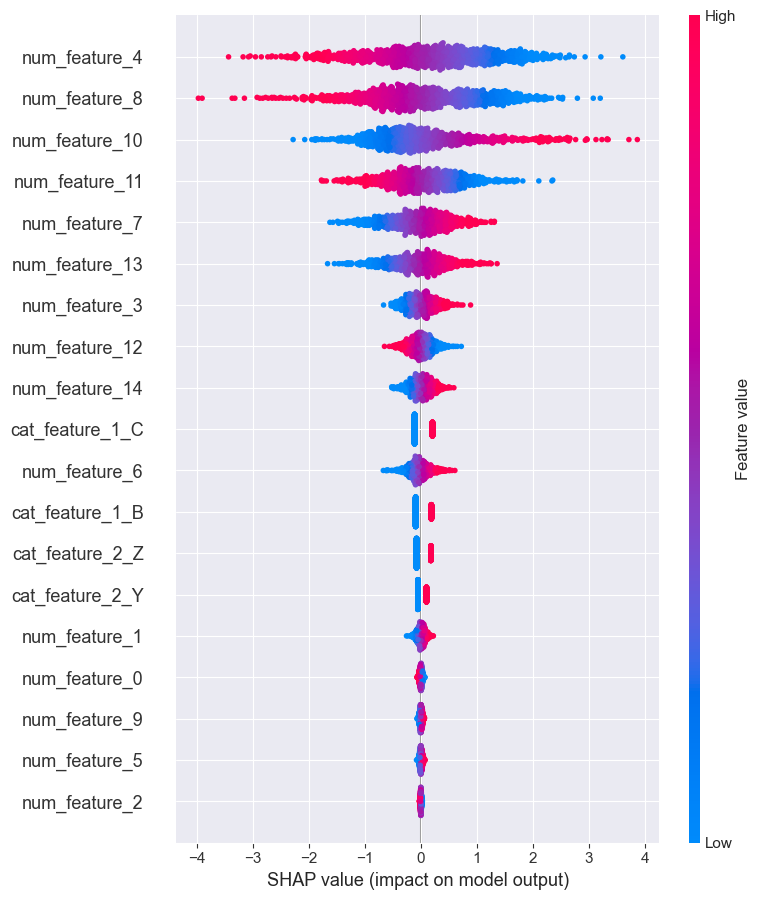

In [5]:
corr_matrix = X_encoded.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
X_corr_filtered = X_encoded.drop(columns=to_drop)

scaler = StandardScaler()
X_scaled_corr = scaler.fit_transform(X_corr_filtered)

model_corr = LogisticRegression()
model_corr.fit(X_scaled_corr, y)

explainer_corr = shap.LinearExplainer(model_corr, X_scaled_corr)
shap_values_corr = explainer_corr.shap_values(X_scaled_corr)

shap.summary_plot(shap_values_corr, X_corr_filtered, feature_names=X_corr_filtered.columns)

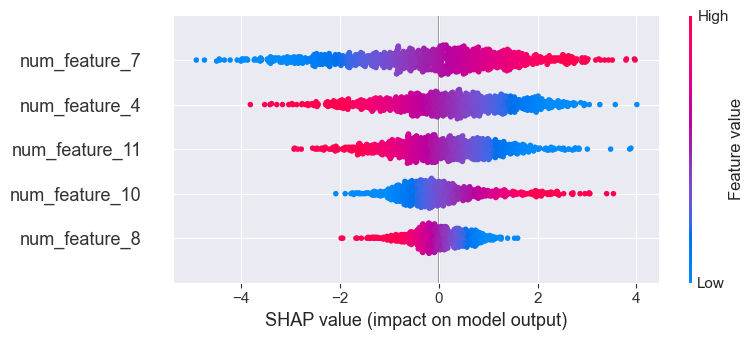

In [6]:
model_rfe = LogisticRegression()
rfe = RFE(model_rfe, n_features_to_select=5)
rfe.fit(X_encoded, y)
X_rfe_filtered = X_encoded.loc[:, rfe.support_]

X_scaled_rfe = scaler.fit_transform(X_rfe_filtered)

model_rfe.fit(X_scaled_rfe, y)

explainer_rfe = shap.LinearExplainer(model_rfe, X_scaled_rfe)
shap_values_rfe = explainer_rfe.shap_values(X_scaled_rfe)

shap.summary_plot(shap_values_rfe, X_rfe_filtered, feature_names=X_rfe_filtered.columns)


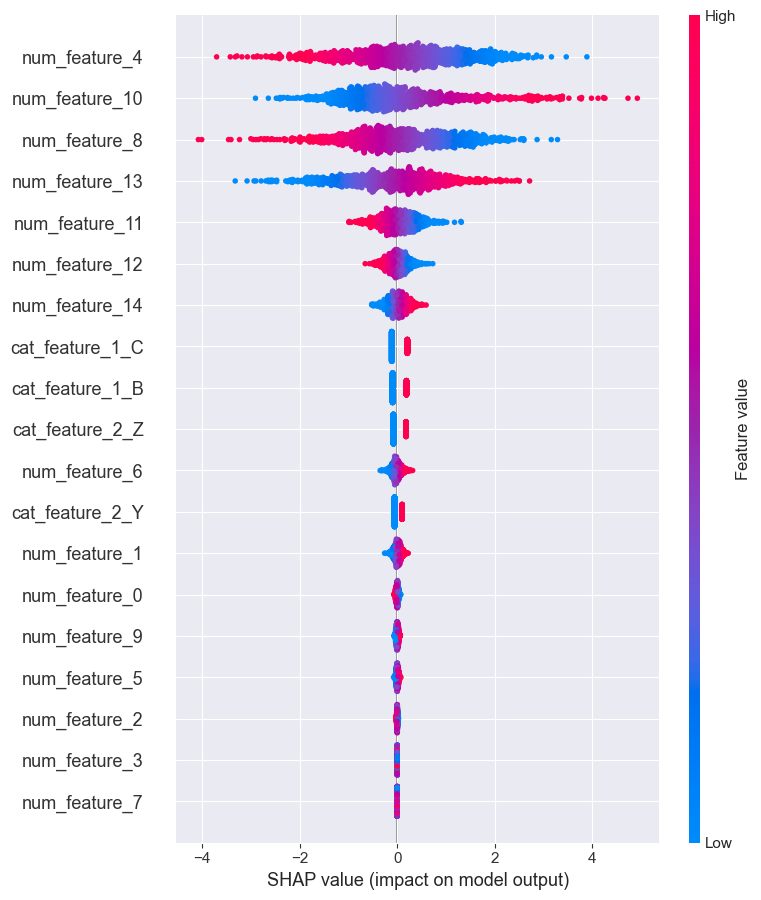

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1/0.1)
model_lasso.fit(X_scaled, y)

selected_features_lasso = X_encoded.columns[model_lasso.coef_.ravel() != 0]
X_lasso_filtered = X_encoded[selected_features_lasso]

explainer_lasso = shap.LinearExplainer(model_lasso, X_scaled)
shap_values_lasso = explainer_lasso.shap_values(X_scaled)

shap.summary_plot(shap_values_lasso, X_encoded, feature_names=X_encoded.columns)


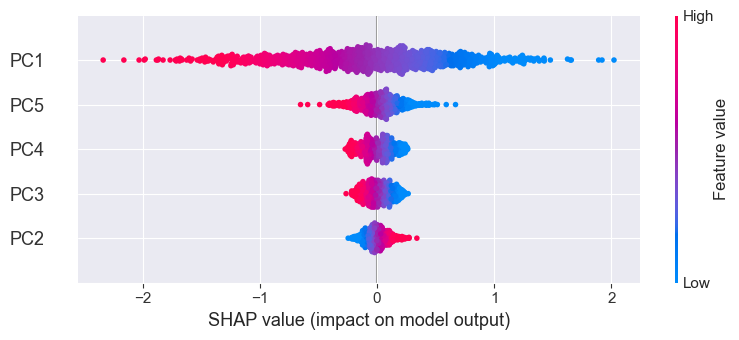

In [34]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

model_pca = LogisticRegression()
model_pca.fit(X_pca, y)

explainer_pca = shap.LinearExplainer(model_pca, X_pca)
shap_values_pca = explainer_pca.shap_values(X_pca)

shap.summary_plot(shap_values_pca, X_pca, feature_names=[f'PC{i+1}' for i in range(X_pca.shape[1])])


Selected features by Boruta: Index(['num_feature_3', 'num_feature_4', 'num_feature_6', 'num_feature_7',
       'num_feature_8', 'num_feature_10', 'num_feature_11', 'num_feature_13'],
      dtype='object')


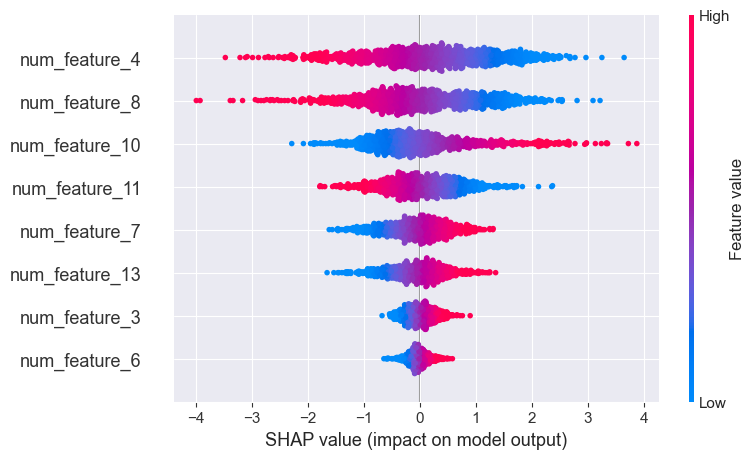

In [38]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta_selector.fit(X_scaled, y)

selected_features_boruta = X_encoded.columns[boruta_selector.support_]
X_boruta_filtered = X_encoded[selected_features_boruta]

print(f"Selected features by Boruta: {selected_features_boruta}")

X_boruta_scaled = scaler.fit_transform(X_boruta_filtered)
model_boruta = LogisticRegression()
model_boruta.fit(X_boruta_scaled, y)

explainer_boruta = shap.LinearExplainer(model_boruta, X_boruta_scaled)
shap_values_boruta = explainer_boruta.shap_values(X_boruta_scaled)

shap.summary_plot(shap_values_boruta, X_boruta_filtered, feature_names=X_boruta_filtered.columns)
